# PART 2 : Definition of a metric

This assignment aims to develop a custom metric that reflects the relative relevance and links between numerical and categorical elements in a dataset by capturing dissimilarity across them. In order to provide a more comprehensive measure of dissimilarity, the metric is made to balance the contributions of other features while being sensitive to the minor differences between various "favorite music styles."

Since the MinMaxScaler technique from scikit-learn modifies the data to fit inside a defined range, usually [0, 1], we will be utilizing it to normalize numerical features. This makes sure that no single numerical trait dominates because of its scale, but rather that each one contributes proportionately to the dissimilarity.

-----

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
from typing import Dict, Any
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# loading the dataset
dataset = pd.read_csv('dataset.csv')

## Preprocessing and normalization of the data

- We would normalize the numerical data in the part to put every value on the same scale when ultimately computing the dissimilarity metric.

In [25]:
"""
Let's initialize the scaler using ...
"""
scaler = MinMaxScaler()

# Apply the scaler to the numerical columns of the data
numerical_features = ['age', 'height'] 
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

### Handling Categorical Data

- `job`, `city`: Used binary dissimilarity, where matching categories score 0, and non-matching score 1.
- `favorite music style`: Established a genre-based dissimilarity matrix, assigning scores by how related they are.

## Defining the custom dissimilarity metric

We should isolate the different kind of styles that appears at once in the dataset

In [26]:

unique_music_styles = dataset['favorite music style'].unique()
print(unique_music_styles)


['trap' 'hiphop' 'metal' 'rock' 'rap' 'classical' 'other' 'jazz'
 'technical death metal']


------
From now on we can focus on defining a weight relationship between all of the different music style : base on a scale of 0 to 1, closer to one meaning the dissimilarity is higher.  

-----

In [27]:
genre_dissimilarity = {
    "trap": {"hiphop": 0.1, "rap": 0.2, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "hiphop": {"trap": 0.1, "rap": 0.1, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "rap": {"trap": 0.2, "hiphop": 0.1, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "metal": {"trap": 0.8, "hiphop": 0.8, "rap": 0.8, "rock": 0.4, "classical": 0.7, "jazz": 0.6, "technical death metal": 0.1, "other": 0.5},
    "rock": {"trap": 0.7, "hiphop": 0.7, "rap": 0.7, "metal": 0.4, "classical": 0.6, "jazz": 0.5, "technical death metal": 0.45, "other": 0.5},
    "classical": {"trap": 0.9, "hiphop": 0.9, "rap": 0.9, "metal": 0.7, "rock": 0.6, "jazz": 0.4, "technical death metal": 0.75, "other": 0.5},
    "jazz": {"trap": 0.8, "hiphop": 0.8, "rap": 0.8, "metal": 0.6, "rock": 0.5, "classical": 0.4, "technical death metal": 0.65, "other": 0.5},
    "technical death metal": {"trap": 0.85, "hiphop": 0.85, "rap": 0.85, "metal": 0.1, "rock": 0.45, "classical": 0.75, "jazz": 0.65, "other": 0.5},
    "other": {"trap": 0.5, "hiphop": 0.5, "rap": 0.5, "metal": 0.5, "rock": 0.5, "classical": 0.5, "jazz": 0.5, "technical death metal": 0.5},
}

def music_style_dissimilarity(style1: str, style2: str) -> float:
    # Direct lookup from the predefined matrix, defaulting to maximum dissimilarity (1.0)
    return genre_dissimilarity.get(style1, {}).get(style2, 1.0)



## Creating the metric

Considering the different kind of features, let's define a metric to put some lights on the importance of some choosen features.

For example, in the following functions, we will take care to outline the repartition of the height of people by their cities.


In [28]:
def enhanced_dissimilarity(sample1: Dict[str, Any], sample2: Dict[str, Any]) -> float:
    """
    Calculate the dissimilarity between two samples based on numerical, categorical, 
    and specific music style features.

    Parameters:
    - sample1 (Dict[str, Any]): A dictionary representing the feature values of the first sample.
    - sample2 (Dict[str, Any]): A dictionary representing the feature values of the second sample.
    
    Returns:
    - float: The aggregated dissimilarity score between sample1 and sample2. This score is a float 
      value that ranges from 0 (identical samples) to a positive number, with higher values 
      indicating greater dissimilarity.

    """

    dissimilarity = 0.0
     # let's say that this is a primary feature
    weight_numerical_height = 1.5
    
    # this is a secondary feature
    weight_categorical_city = 1.5 
    
    # Lower weights for other features
    weight_numerical_age = 0.8
    weight_categorical_job = 0.7
    weight_music_style = 0.5
    
    # Handle 'height' and 'age' by their specific weight
    diff = sample1['height'] - sample2['height']
    dissimilarity += (np.square(diff) * weight_numerical_height)
    
    diff = sample1['age'] - sample2['age']
    dissimilarity += (np.square(diff) * weight_numerical_age)
    
    # Binary handling for categorical features with specific weights
    for feature in ['job', 'city']:
        if feature == 'city':
            if sample1[feature] != sample2[feature]:
                dissimilarity += weight_categorical_city
        else:
            if sample1[feature] != sample2[feature]:
                dissimilarity += weight_categorical_job
    
    # Music style dissimilarity calculation with its specific weight
    music_style_diff = music_style_dissimilarity(sample1['favorite music style'], sample2['favorite music style'])
    dissimilarity += music_style_diff * weight_music_style
    
    return np.sqrt(dissimilarity)

-----
Now let's produce the dissimilarity matrix

-----

In [29]:
def compute_dissimilarity_matrix(dataset: pd.DataFrame) -> np.ndarray:
    """
    Compute the dissimilarity matrix for a dataset.
    
    Parameters:
    - dataset (pd.DataFrame): A pandas DataFrame where each row is a sample, and each column is a feature.

    Returns:
    - np.ndarray: A symmetric matrix where element [i, j] represents the dissimilarity between
      sample i and sample j from the dataset.
    """
    num_samples = len(dataset)
    dissimilarity_matrix = np.zeros((num_samples, num_samples))

    # Calculate the dissimilarity score between each pair of samples.
    for i in range(num_samples):
        for j in range(i, num_samples):  # Only compute half the matrix due to symmetry.
            sample1 = dataset.iloc[i].to_dict()
            sample2 = dataset.iloc[j].to_dict()

            # Use the custom dissimilarity function defined earlier.
            dissimilarity = enhanced_dissimilarity(sample1, sample2)

            # Fill the matrix with the dissimilarity score for both [i, j] and [j, i].
            dissimilarity_matrix[i, j] = dissimilarity
            dissimilarity_matrix[j, i] = dissimilarity

    return dissimilarity_matrix

# Compute the dissimilarity matrix
dissimilarity_matrix = compute_dissimilarity_matrix(dataset)
np.save('dissimilarity_matrix.npy', dissimilarity_matrix)
dissimilarity_matrix = np.load('dissimilarity_matrix.npy')


----
Let's load the matrix and look at it under different plotting system :

----

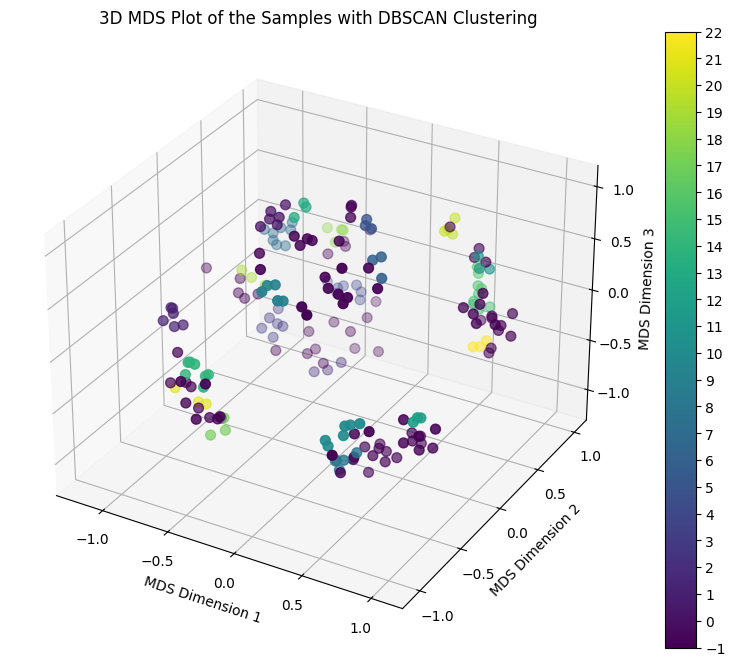

In [30]:
# DBSCAN 3D

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42, normalized_stress=False)
data_3d = mds.fit_transform(dissimilarity_matrix)
dbscan = DBSCAN(eps=0.9, min_samples=3)
labels = dbscan.fit_predict(dissimilarity_matrix)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster labels
sc = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=labels, cmap='viridis', s=50)

# Title and labels
ax.set_title('3D MDS Plot of the Samples with DBSCAN Clustering')
ax.set_xlabel('MDS Dimension 1')
ax.set_ylabel('MDS Dimension 2')
ax.set_zlabel('MDS Dimension 3')

# Colorbar to show the cluster colors
plt.colorbar(sc, ticks=np.unique(labels))

plt.show()

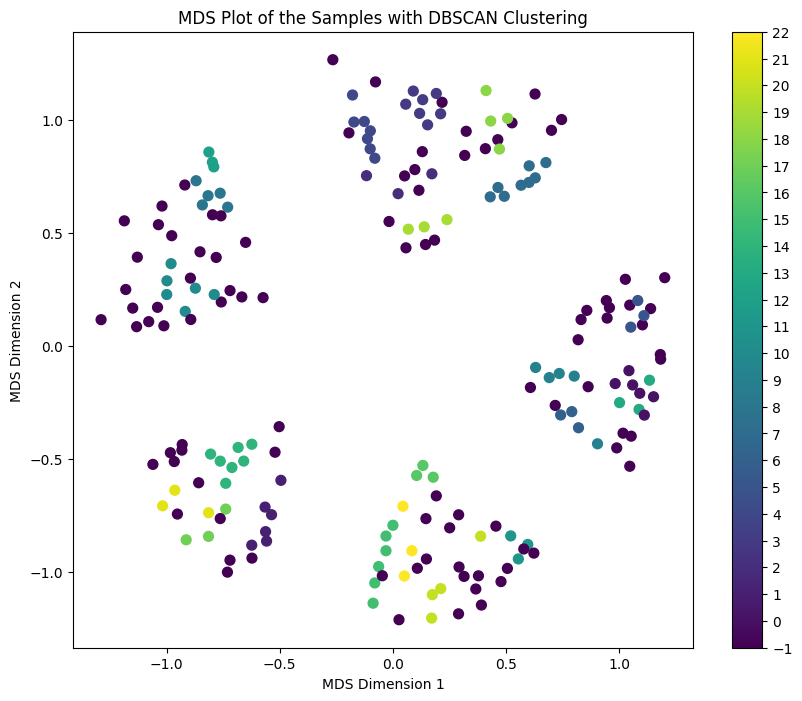

In [31]:
# DBSCAN

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, normalized_stress=False)
data_2d = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS reduced data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=50)
plt.title('MDS Plot of the Samples with DBSCAN Clustering')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')

# DBSCAN labels -1 for noise
if np.any(labels == -1):
    plt.colorbar(scatter, ticks=np.unique(labels))
else:
    plt.colorbar(scatter)

plt.show()

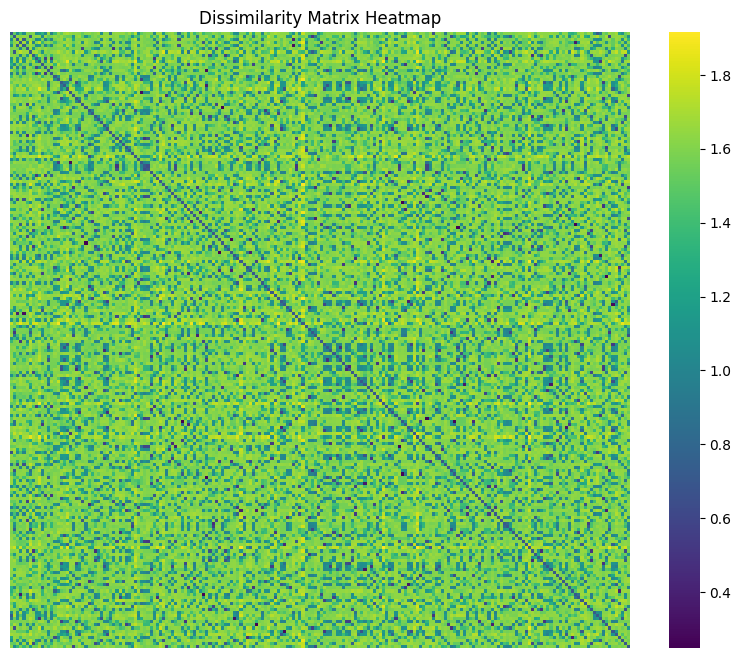

In [32]:
# HEATMAP

plt.figure(figsize=(10, 8))
sns.heatmap(dissimilarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Dissimilarity Matrix Heatmap')
plt.show()

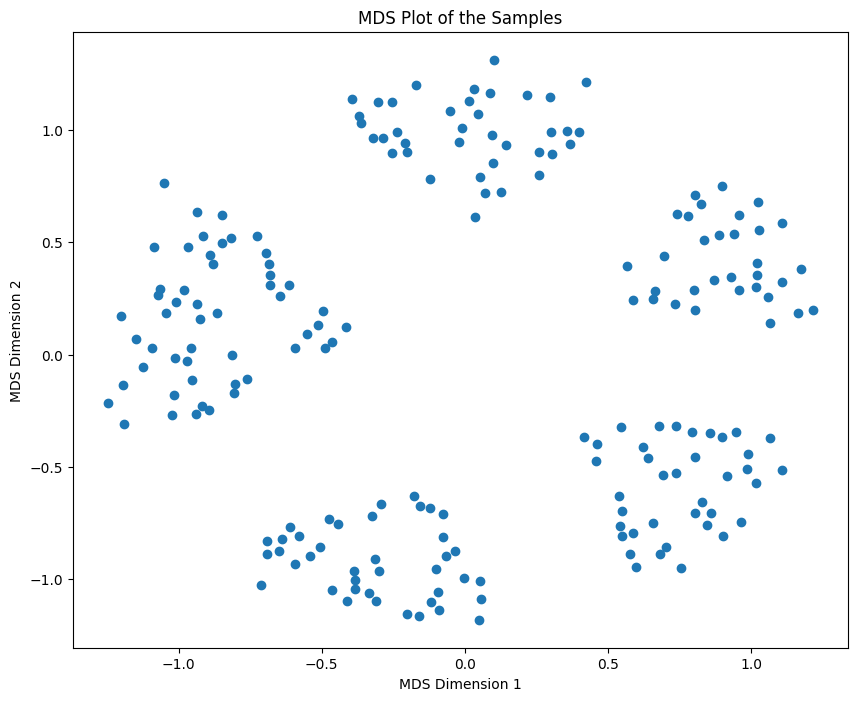

In [33]:
# MDS PLOT

mds = MDS(n_components=2, dissimilarity="precomputed", normalized_stress=False)
mds_coords = mds.fit_transform(dissimilarity_matrix)
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
plt.title("MDS Plot of the Samples")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

## Conclusion

The clustering analysis using DBSCAN and visualized through Multidimensional Scaling (MDS) has successfully identified distinct groupings within the dataset, indicating meaningful patterns based on the attributes of height in relation to the city. 

The heatmap supports these findings by displaying the variations in dissimilarity across the dataset.




Pol-Antoine Loiseau - Florent Rossignol